## Creating datasets for analysis 




In [ ]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import grangercausalitytests

def generate_causal_data(n_samples=1000, seed=42):
    np.random.seed(seed)
    
    # Generate independent variable
    x = np.random.normal(0, 1, n_samples)
    
    # Generate dependent variable with lag
    y = np.zeros(n_samples)
    for t in range(2, n_samples):
        y[t] = 0.5 * x[t-1] + 0.3 * x[t-2] + np.random.normal(0, 0.5)
    
    # Create DataFrame
    df = pd.DataFrame({'x': x, 'y': y})
    
    return df

# Generate data
data = generate_causal_data()

# Test for Granger causality
granger_test = grangercausalitytests(data[['y', 'x']], maxlag=5, verbose=False)

# Print results
for lag, results in granger_test.items():
    print(f"Lag {lag}: p-value = {results[0]['ssr_ftest'][1]}")

In [ ]:
import pytorch_forecasting
from collections.abc import Iterable
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics import MAE
import pytorch_lightning as pl

# Prepare data
data['time_idx'] = range(len(data))
data['static_col'] = 0  # Dummy static column

# Create dataset
max_encoder_length = 5
max_prediction_length = 1

training = TimeSeriesDataSet(
    data,
    time_idx="time_idx",
    target="y",
    group_ids=["static_col"],
    static_categoricals=["static_col"],
    time_varying_known_reals=["x"],
    time_varying_unknown_reals=["y"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
)

# Create dataloaders
batch_size = 32
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)

# Initialize model
model = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=1e-3,
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=MAE(),
    log_interval=10,
    reduce_on_plateau_patience=4
)

# Train the model
trainer = pl.Trainer(max_epochs=100, gpus=0)
trainer.fit(model, train_dataloaders=train_dataloader)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your trained TFT model
# and 'train_dataloader' is your DataLoader

# Get a batch of data
x, y = next(iter(train_dataloader))

# Get attention weights
interpretation = model.interpret_output(model(x), attention_prediction_horizon=0)
attention = interpretation["attention"]

# Extract static variables and time-varying known inputs attention
static_attention = attention[0].mean(0).cpu().detach().numpy()
temporal_attention = attention[1][0].mean(0).cpu().detach().numpy()

# Visualize temporal attention
plt.figure(figsize=(10, 6))
sns.heatmap(temporal_attention, cmap='YlOrRd')
plt.title('Temporal Attention Weights')
plt.xlabel('Time Steps (Past)')
plt.ylabel('Variables')
plt.show()

# Print static variable importance
print("Static Variable Importance:", static_attention)

In [96]:

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

ModuleNotFoundError: No module named 'darts'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        # Attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention, weights = self.attention(value, key, query)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, weights

class Encoder(nn.Module):
    def __init__(
        self,
        input_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Linear(input_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [
                TransformerBlock(
                    embed_size,
                    heads,
                    dropout=dropout,
                    forward_expansion=forward_expansion,
                )
                for _ in range(num_layers)
            ]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, seq_length, _ = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        out = self.dropout(
            self.word_embedding(x) + self.position_embedding(positions)
        )

        attentions = []
        for layer in self.layers:
            out, attention = layer(out, out, out)
            attentions.append(attention)

        return out, attentions

class TimeSeriesTransformer(nn.Module):
    def __init__(
        self,
        input_size,
        embed_size,
        num_layers,
        heads,
        forward_expansion,
        dropout,
        max_length,
    ):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = Encoder(
            input_size,
            embed_size,
            num_layers,
            heads,
            forward_expansion,
            dropout,
            max_length,
        )
        
        self.decoder = nn.Linear(embed_size, 1)
        
    def forward(self, src):
        encoder_out, attentions = self.encoder(src)
        out = self.decoder(encoder_out)
        return out[:, -1, :], attentions  # Return only the last time step prediction

# Generate synthetic data
def generate_data(n_samples=1000):
    t = np.arange(n_samples)
    x = np.sin(0.02 * t) + np.random.normal(0, 0.1, n_samples)
    y = np.zeros(n_samples)
    for i in range(2, n_samples):
        y[i] = 0.6 * x[i-1] + 0.3 * x[i-2] + np.random.normal(0, 0.1)
    return torch.tensor(np.column_stack((x, y)), dtype=torch.float32)

# Prepare data for training
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length, 1]
        sequences.append(seq)
        targets.append(target)
    return torch.stack(sequences), torch.tensor(targets).unsqueeze(1)

# Generate data
data = generate_data()
seq_length = 10
X, y = create_sequences(data, seq_length)

# Initialize model
model = TimeSeriesTransformer(
    input_size=2,
    embed_size=64,
    num_layers=2,
    heads=4,
    forward_expansion=2,
    dropout=0.1,
    max_length=seq_length
)

# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred, _ = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Visualize attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X[:1])

# We'll visualize the attention from the last layer
last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()

plt.figure(figsize=(10, 6))
plt.imshow(last_layer_attention, cmap='viridis')
plt.colorbar()
plt.title('Attention Weights (Last Layer)')
plt.xlabel('Input Sequence')
plt.ylabel('Input Sequence')
plt.show()

# Print average attention weights for each time step
avg_attention = last_layer_attention.mean(axis=0)
for i, weight in enumerate(avg_attention):
    print(f"Average attention weight for time step t-{seq_length-i}: {weight:.4f}")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention, weights = self.attention(value, key, query)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, weights

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Linear(input_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, seq_length, _ = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        attentions = []
        for layer in self.layers:
            out, attention = layer(out, out, out)
            attentions.append(attention)

        return out, attentions

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = Encoder(input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length)
        self.decoder = nn.Linear(embed_size, 1)
        
    def forward(self, src):
        encoder_out, attentions = self.encoder(src)
        out = self.decoder(encoder_out)
        return out[:, -1, :], attentions  # Return only the last time step prediction

def generate_data(n_samples=1000):
    # Generate independent variable
    x = np.random.normal(0, 1, n_samples)
    
    # Generate dependent variable with lag
    y = np.zeros(n_samples)
    for t in range(2, n_samples):
        y[t] = 0.6 * x[t-5] + 0.6 * x[t-2] #+ np.random.normal(0, 0.5)
    
    # Create DataFrame
    df = pd.DataFrame({'x': x, 'y': y})
    return df

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values
        target = data.iloc[i+seq_length]['y']
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

# Generate data
data = generate_data(n_samples=1000)
seq_length = 10
X, y = create_sequences(data, seq_length)

# Initialize model
model = TimeSeriesTransformer(
    input_size=2,
    embed_size=64,
    num_layers=2,
    heads=4,
    forward_expansion=2,
    dropout=0.1,
    max_length=seq_length
)

# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
losses = []
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred, _ = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')


# Visualize attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X[:1])

# We'll visualize the attention from the last layer
last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()


plt.figure(figsize=(10, 6))
plt.imshow(last_layer_attention, cmap='viridis')
plt.colorbar()
plt.title('Attention Weights (Last Layer)')
plt.xlabel('Input Sequence')
plt.ylabel('Input Sequence')
plt.show()

# Print average attention weights for each time step
avg_attention = last_layer_attention.mean(axis=0)
for i, weight in enumerate(avg_attention):
    print(f"Average attention weight for time step t-{seq_length-i}: {weight:.4f}")

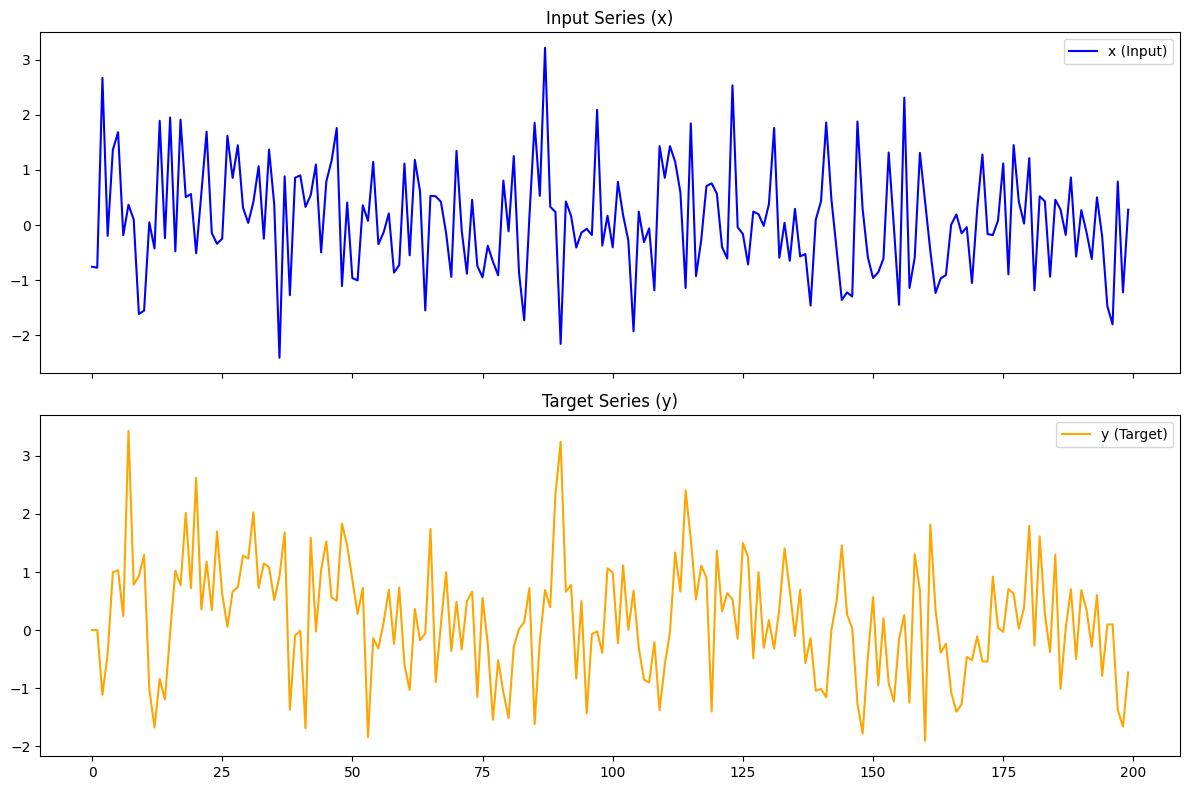

Epoch [10/100], Loss: 0.9976
Epoch [20/100], Loss: 0.8379
Epoch [30/100], Loss: 0.5854
Epoch [40/100], Loss: 0.3110
Epoch [50/100], Loss: 0.2395
Epoch [60/100], Loss: 0.1942
Epoch [70/100], Loss: 0.1689
Epoch [80/100], Loss: 0.1353
Epoch [90/100], Loss: 0.1254
Epoch [100/100], Loss: 0.1081


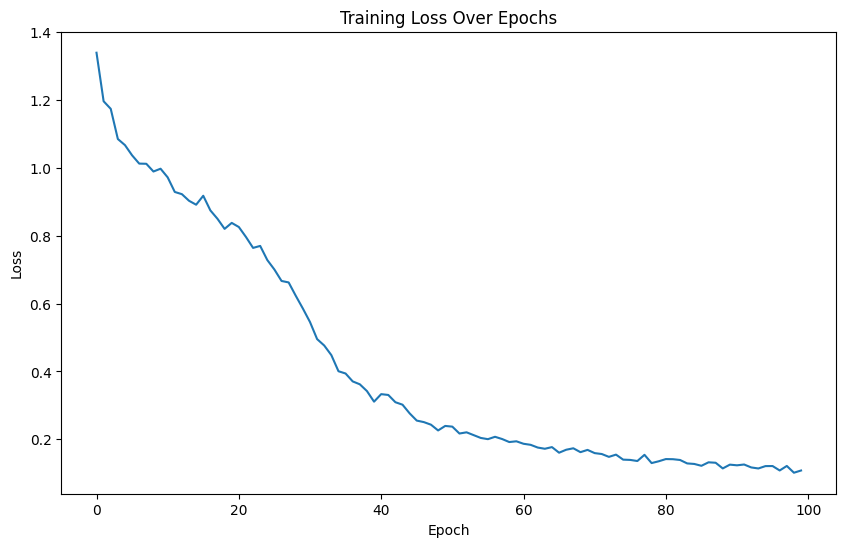

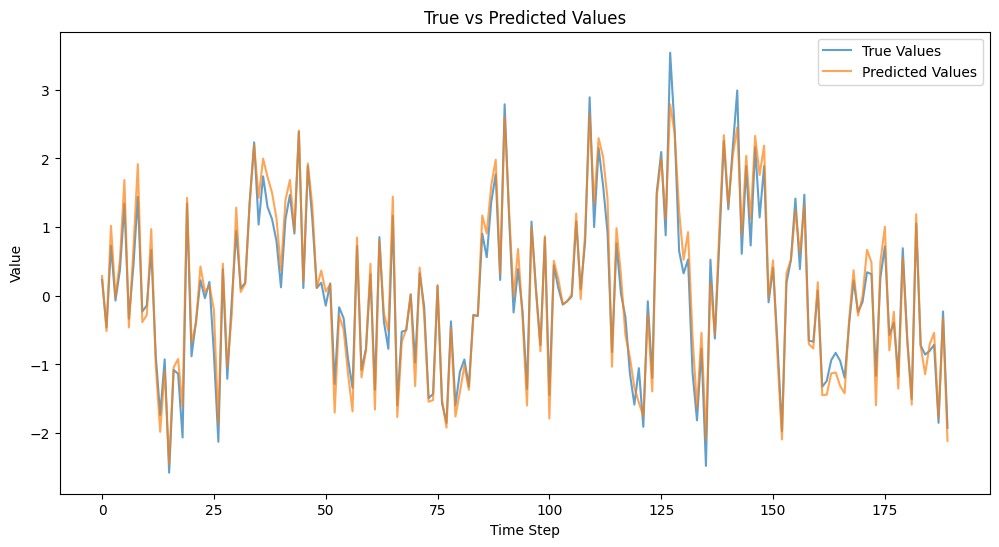

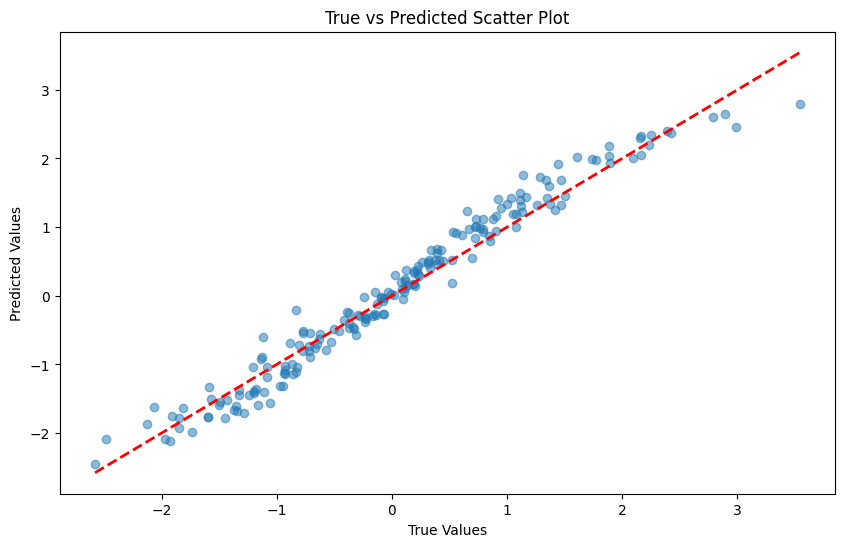

MSE: 0.053453144


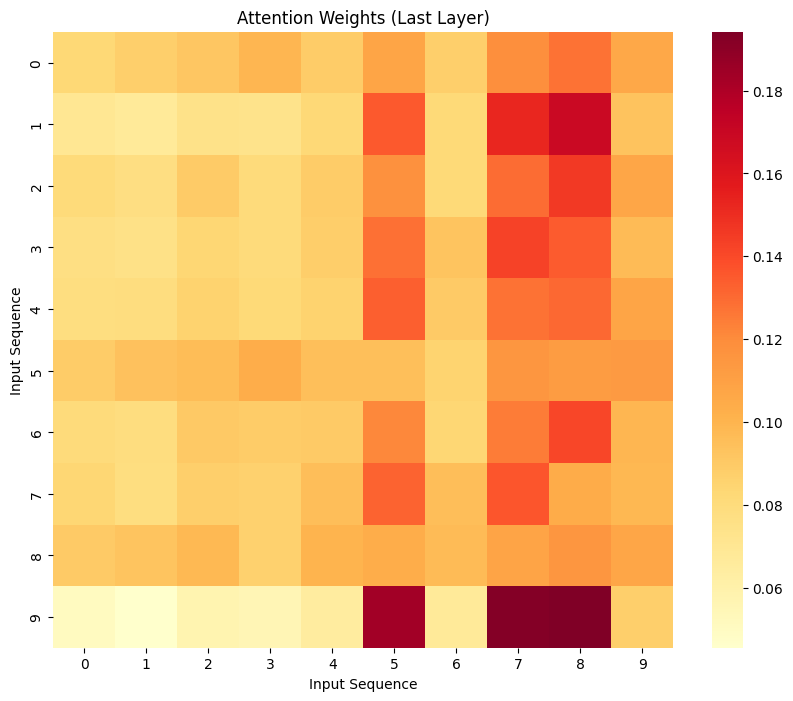

Average attention weight for time step t-10: 0.0784
Average attention weight for time step t-9: 0.0777
Average attention weight for time step t-8: 0.0855
Average attention weight for time step t-7: 0.0838
Average attention weight for time step t-6: 0.0880
Average attention weight for time step t-5: 0.1259
Average attention weight for time step t-4: 0.0862
Average attention weight for time step t-3: 0.1350
Average attention weight for time step t-2: 0.1376
Average attention weight for time step t-1: 0.1019


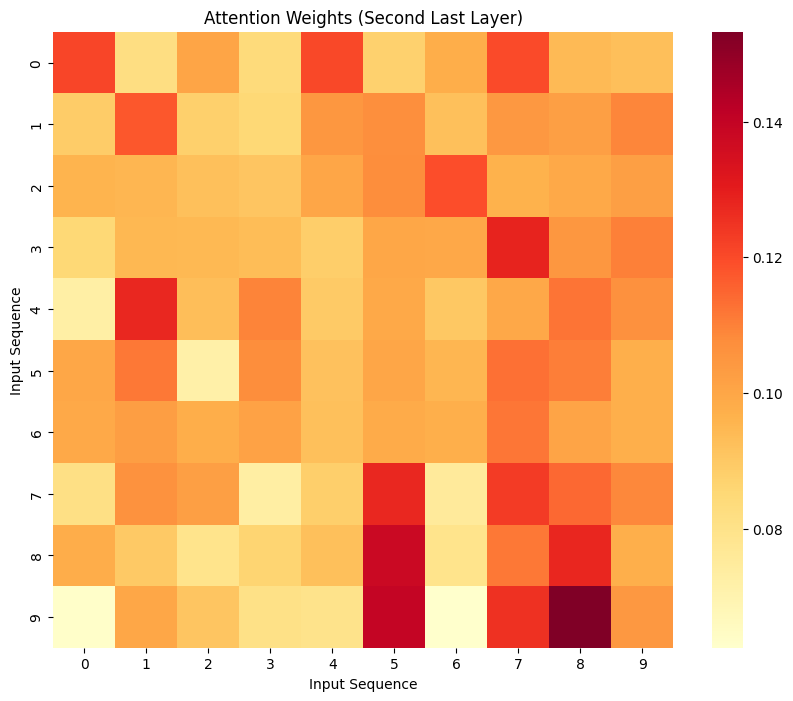

Average attention weight for time step t-10: 0.0784
Average attention weight for time step t-9: 0.0777
Average attention weight for time step t-8: 0.0855
Average attention weight for time step t-7: 0.0838
Average attention weight for time step t-6: 0.0880
Average attention weight for time step t-5: 0.1259
Average attention weight for time step t-4: 0.0862
Average attention weight for time step t-3: 0.1350
Average attention weight for time step t-2: 0.1376
Average attention weight for time step t-1: 0.1019


In [94]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#np.random.seed(42)
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size moet je kunnen delen door heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention, weights = self.attention(value, key, query)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, weights

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Linear(input_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, seq_length, _ = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        attentions = []
        for layer in self.layers:
            out, attention = layer(out, out, out)
            attentions.append(attention)

        return out, attentions

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = Encoder(input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length)
        self.decoder = nn.Linear(embed_size, 1)
        
    def forward(self, src):
        encoder_out, attentions = self.encoder(src)
        out = self.decoder(encoder_out)
        return out[:, -1, :], attentions



def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values
        target = data.iloc[i+seq_length]['y']
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

def plot_original_data(df, figsize=(12, 8), start_idx=0, end_idx=200):
    plot_data = df.iloc[start_idx:end_idx]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Plot x
    ax1.plot(plot_data.index, plot_data['x'], label='x (Input)', color='blue')
    ax1.set_title('Input Series (x)')
    ax1.legend()
    
    # Plot y
    ax2.plot(plot_data.index, plot_data['y'], label='y (Target)', color='orange')
    ax2.set_title('Target Series (y)')
    ax2.legend()

    
    plt.tight_layout()
    plt.show()
    


def plot_true_vs_predicted(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred, _ = model(X)
    
    y_pred = y_pred.numpy().flatten()
    y_true = y.numpy().flatten()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', alpha=0.7)
    plt.plot(y_pred, label='Predicted Values', alpha=0.7)
    plt.title('True vs Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Scatter Plot')
    plt.show()
    print("MSE:", mean_squared_error(y_true, y_pred))

def plot_loss_over_epochs(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_attention_weights(attentions, seq_length):
    last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(last_layer_attention, cmap='YlOrRd')
    plt.title('Attention Weights (Last Layer)')
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.show()
    
    avg_attention = last_layer_attention.mean(axis=0)
    for i, weight in enumerate(avg_attention):
        print(f"Average attention weight for time step t-{seq_length-i}: {weight:.4f}")
    
    second_last_layer_attention = attentions[-2].squeeze().mean(dim=0).numpy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(second_last_layer_attention, cmap='YlOrRd')
    plt.title('Attention Weights (Second Last Layer)')
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.show()
    
    avg_attention = last_layer_attention.mean(axis=0)
    for i, weight in enumerate(avg_attention):
        print(f"Average attention weight for time step t-{seq_length-i}: {weight:.4f}")
        
def generate_data(n_samples=1000):
    x = np.random.normal(0, 1, n_samples)
    y = np.zeros(n_samples)
    for t in range(2, n_samples):
         y[t] = 0.6 * x[t-5] + 0.6 * x[t-2] + 0.6 * x[t-3] #+ np.random.normal(0, 0.5)
    return pd.DataFrame({'x': x, 'y': y})
# Generate data
data = generate_data(n_samples=1000)
plot_original_data(data)

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Prepare sequences
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Initialize model
model = TimeSeriesTransformer(
    input_size=2,
    embed_size=64,
    num_layers=2,
    heads=4,
    forward_expansion=2,
    dropout=0.1,
    max_length=seq_length
)

# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred, _ = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Plot loss over epochs
plot_loss_over_epochs(losses)

# Plot true vs predicted
plot_true_vs_predicted(model, X_test, y_test)

# Visualize attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X_test[:1])
plot_attention_weights(attentions, seq_length)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_temporal_attention_heatmap(attention_weights, seq_length):
    plt.figure(figsize=(12, 8))
    time_labels = [f't-{i}' for i in range(seq_length, 0, -1)]
    
    # Create a mask for the upper triangle to emphasize temporal direction
    mask = np.triu(np.ones_like(attention_weights, dtype=bool))
    
    sns.heatmap(attention_weights, 
                xticklabels=time_labels, 
                yticklabels=time_labels,
                cmap='YlOrRd',
                mask=mask)
    plt.title('Temporal Attention Weights Heatmap')
    plt.xlabel('From Time Step')
    plt.ylabel('To Time Step')
    plt.show()

# After running your model
model.eval()
with torch.no_grad():
    _, attentions = model(X_test[:1])

# Get the last layer's attention weights
last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()

# Plot the temporal heatmap
plot_temporal_attention_heatmap(last_layer_attention, seq_length)

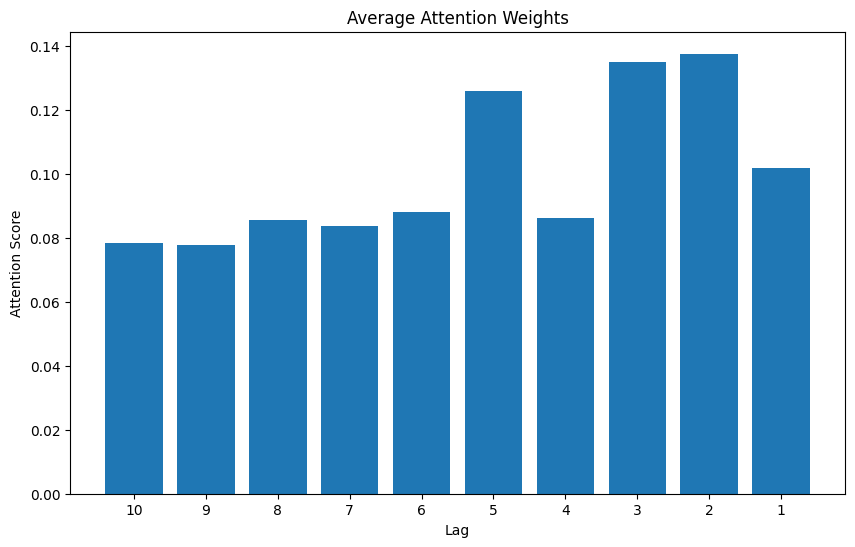

Detected causal relationships:
Lag 2: Avg Weight = 0.1376, Max Weight = 0.1942
Lag 3: Avg Weight = 0.1350, Max Weight = 0.1928
Lag 5: Avg Weight = 0.1259, Max Weight = 0.1836
Estimated primary lag: 2


In [95]:
def analyze_causal_relationship(attentions, seq_length, threshold=0.15):
    last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()
    avg_attention = last_layer_attention.mean(axis=0)
    max_attention = last_layer_attention.max(axis=0)
    
    significant_lags = []
    for i, (avg_weight, max_weight) in enumerate(zip(avg_attention, max_attention)):
        lag = seq_length - i
        if avg_weight > threshold or max_weight > threshold:
            significant_lags.append((lag, avg_weight, max_weight))
    
    significant_lags.sort(key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(10, 6))
    lags = range(seq_length, 0, -1)  # Create correct lag labels
    plt.bar(lags, last_layer_attention.mean(axis=0))
    plt.title('Average Attention Weights')
    plt.xlabel('Lag')
    plt.ylabel('Attention Score')
    plt.xticks(lags)  # Set x-ticks to show all lags
    plt.gca().invert_xaxis()  # Invert x-axis to show lags in ascending order
    plt.show()
    
    if significant_lags:
        print("Detected causal relationships:")
        for lag, avg_weight, max_weight in significant_lags:
            print(f"Lag {lag}: Avg Weight = {avg_weight:.4f}, Max Weight = {max_weight:.4f}")
        return significant_lags
    else:
        print("No clear causal relationship detected")
        return None

# After training the model and getting the attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X_test[:1])

significant_lags = analyze_causal_relationship(attentions, seq_length)

if significant_lags:
    estimated_lag = significant_lags[0][0]
    print(f"Estimated primary lag: {estimated_lag}")
else:
    print("Could not estimate lag")

In [ ]:
significant_lags

In [ ]:
import numpy as np
from scipy import stats

def permutation_test(attentions, seq_length, n_permutations=1000, alpha=1):
    last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()
    avg_attention = last_layer_attention.mean(axis=0)
    
    def get_max_attention(attention):
        return np.max(attention.mean(axis=0))
    
    observed_statistic = get_max_attention(last_layer_attention)
    
    null_distribution = []
    for _ in range(n_permutations):
        permuted_attention = np.random.permutation(last_layer_attention)
        null_distribution.append(get_max_attention(permuted_attention))
    
    p_value = (sum(null_stat >= observed_statistic for null_stat in null_distribution) + 1) / (n_permutations + 1)
    
    significant_lags = []
    for i, weight in enumerate(avg_attention):
        lag = seq_length - i
        lag_p_value = (sum(null_stat >= weight for null_stat in null_distribution) + 1) / (n_permutations + 1)
        if lag_p_value < alpha:
            significant_lags.append((lag, weight, lag_p_value))
    
    significant_lags.sort(key=lambda x: x[1], reverse=True)
    
    plt.figure(figsize=(10, 5))
    plt.bar(range(seq_length), avg_attention)
    plt.title(f'Average Attention Weights (p-value: {p_value:.4f})')
    plt.xlabel('Lag')
    plt.ylabel('Attention Score')
    plt.show()
    
    if p_value < alpha:
        print(f"Detected overall causal relationship (p-value: {p_value:.4f})")
        print("Significant lags:")
        for lag, weight, lag_p_value in significant_lags:
            print(f"Lag {lag}: Weight = {weight:.4f}, p-value = {lag_p_value:.4f}")
        return significant_lags
    else:
        print(f"No clear causal relationship detected (p-value: {p_value:.4f})")
        return None

# After training the model and getting the attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X_test[:1])

significant_lags = permutation_test(attentions, seq_length)

if significant_lags:
    estimated_lag = significant_lags[0][0]
    print(f"Estimated primary lag: {estimated_lag}")
else:
    print("Could not estimate lag")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class CausalSelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(CausalSelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = CausalSelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention, weights = self.attention(value, key, query, mask)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, weights

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Linear(input_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        N, seq_length, _ = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        attentions = []
        for layer in self.layers:
            out, attention = layer(out, out, out, mask)
            attentions.append(attention)

        return out, attentions

class CausalTimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(CausalTimeSeriesTransformer, self).__init__()
        self.encoder = Encoder(input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length)
        self.decoder = nn.Linear(embed_size, 1)
        self.max_length = max_length
        
    def forward(self, src):
        mask = self.generate_causal_mask(src.shape[1]).to(src.device)
        encoder_out, attentions = self.encoder(src, mask)
        out = self.decoder(encoder_out)
        return out[:, -1, :], attentions

    def generate_causal_mask(self, size):
        mask = torch.tril(torch.ones(size, size)).unsqueeze(0).unsqueeze(1)
        return mask

# Data generation and preparation functions remain the same

def generate_data(n_samples=1000):
    x = np.random.normal(0, 1, n_samples)
    y = np.zeros(n_samples)
    for t in range(5, n_samples):
        y[t] = 0.6 * x[t-5] + 0.6 * x[t-2] + np.random.normal(0, 0.1)
    return pd.DataFrame({'x': x, 'y': y})

def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values
        target = data.iloc[i+seq_length]['y']
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

# Main execution
data = generate_data(n_samples=1000)
seq_length = 10
X, y = create_sequences(data, seq_length)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Initialize model
model = CausalTimeSeriesTransformer(
    input_size=2,
    embed_size=64,
    num_layers=2,
    heads=4,
    forward_expansion=2,
    dropout=0.1,
    max_length=seq_length
)

# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred, _ = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_pred_test, _ = model(X_test)
        test_loss = criterion(y_pred_test, y_test)
        test_losses.append(test_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X_test[:1])

last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()

plt.figure(figsize=(10, 8))
plt.imshow(last_layer_attention, cmap='YlOrRd')
plt.colorbar()
plt.title('Attention Weights (Last Layer)')
plt.xlabel('Input Sequence')
plt.ylabel('Input Sequence')
plt.show()

# Print average attention weights
avg_attention = last_layer_attention.mean(axis=0)
for i, weight in enumerate(avg_attention):
    print(f"Average attention weight for time step t-{seq_length-i}: {weight:.4f}")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Generate synthetic data with multiple variables
def generate_multi_variable_data(n_samples=1000):
    x = np.random.normal(0, 1, n_samples)
    k = np.random.normal(0, 1, n_samples)
    m = np.random.normal(0, 1, n_samples)
    y = np.zeros(n_samples)
    
    for t in range(3, n_samples):  # Start from 3 to have enough history
        y[t] = 0.7 * x[t-2] + 0.7 * k[t-1] + 0.7 * m[t-3] + np.random.normal(0, 0.1)
    
    return pd.DataFrame({'x': x, 'k': k, 'm': m, 'y': y})

# Modified sequence creation for multiple variables
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length][['x', 'k', 'm']].values
        target = data.iloc[i+seq_length]['y']
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

class MultiVariableTransformer(nn.Module):
    def __init__(self, input_size, d_model, nhead, num_layers, dim_feedforward, dropout=0.1):
        super(MultiVariableTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(d_model, 1)
        self.nhead = nhead
        
    def forward(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output[:, -1, :])
        return output

    def get_attention_weights(self, src):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        attention_weights = []
        for layer in self.transformer_encoder.layers:
            _, attn_output_weights = layer.self_attn(src, src, src, need_weights=True)
            attention_weights.append(attn_output_weights)
        return attention_weights

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Generate data
data = generate_multi_variable_data(n_samples=1000)

# Split data and create sequences
seq_length = 10
X, y = create_sequences(data, seq_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize model
model = MultiVariableTransformer(input_size=3, d_model=64, nhead=4, num_layers=2, dim_feedforward=256)

# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)  # Note: model now only returns predictions
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Evaluate model
model.eval()
with torch.no_grad():
    y_pred = model(X_test)
    test_loss = criterion(y_pred, y_test)
    print(f'Test Loss: {test_loss.item():.4f}')

# Get attention weights for visualization
attention_weights = model.get_attention_weights(X_test[:1])  # Get weights for first test sample

# Visualize attention weights
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for i, layer_attention in enumerate(attention_weights):
    layer_attention = layer_attention.squeeze(0).mean(dim=0).numpy()  # Average over attention heads
    sns.heatmap(layer_attention, cmap='YlOrRd', ax=axes[i])
    axes[i].set_title(f'Attention Weights for Layer {i+1}')
    axes[i].set_xlabel('Time Steps and Variables')
    axes[i].set_ylabel('Query Time Steps')
plt.tight_layout()
plt.show()

# Print average attention weights for each variable and time step
seq_length = X_test.shape[1]
variables = ['X', 'K', 'M']
for layer, layer_attention in enumerate(attention_weights):
    print(f"\nLayer {layer+1} Attention:")
    avg_attention = layer_attention.squeeze(0).mean(dim=0).numpy()
    for t in range(seq_length):
        for v, var in enumerate(variables):
            print(f"Average attention for {var} at t-{seq_length-t}: {avg_attention[t*3 + v]:.4f}")

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
np.random.seed(42)
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (self.head_dim * heads == embed_size), "Embed size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        query = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(query)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])
        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3)
        
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )

        out = self.fc_out(out)
        return out, attention

class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion):
        super(TransformerBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query):
        attention, weights = self.attention(value, key, query)

        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, weights

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(Encoder, self).__init__()
        self.embed_size = embed_size
        self.word_embedding = nn.Linear(input_size, embed_size)
        self.position_embedding = nn.Embedding(max_length, embed_size)

        self.layers = nn.ModuleList(
            [TransformerBlock(embed_size, heads, dropout, forward_expansion) for _ in range(num_layers)]
        )

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        N, seq_length, _ = x.shape
        positions = torch.arange(0, seq_length).expand(N, seq_length).to(x.device)
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))

        attentions = []
        for layer in self.layers:
            out, attention = layer(out, out, out)
            attentions.append(attention)

        return out, attentions

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):
        super(TimeSeriesTransformer, self).__init__()
        self.encoder = Encoder(input_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length)
        self.decoder = nn.Linear(embed_size, 1)
        
    def forward(self, src):
        encoder_out, attentions = self.encoder(src)
        out = self.decoder(encoder_out)
        return out[:, -1, :], attentions



def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values
        target = data.iloc[i+seq_length]['y']
        sequences.append(seq)
        targets.append(target)
    return torch.tensor(sequences, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

def plot_original_data(df, figsize=(12, 8), start_idx=0, end_idx=200):
    plot_data = df.iloc[start_idx:end_idx]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Plot x
    ax1.plot(plot_data.index, plot_data['x'], label='x (Input)', color='blue')
    ax1.set_title('Input Series (x)')
    ax1.legend()
    
    # Plot y
    ax2.plot(plot_data.index, plot_data['y'], label='y (Target)', color='orange')
    ax2.set_title('Target Series (y)')
    ax2.legend()

    
    plt.tight_layout()
    plt.show()
    


def plot_true_vs_predicted(model, X, y):
    model.eval()
    with torch.no_grad():
        y_pred, _ = model(X)
    
    y_pred = y_pred.numpy().flatten()
    y_true = y.numpy().flatten()
    
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values', alpha=0.7)
    plt.plot(y_pred, label='Predicted Values', alpha=0.7)
    plt.title('True vs Predicted Values')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title('True vs Predicted Scatter Plot')
    plt.show()
    print("MSE:", mean_squared_error(y_true, y_pred))

def plot_loss_over_epochs(losses):
    plt.figure(figsize=(10, 6))
    plt.plot(losses)
    plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

def plot_attention_weights(attentions, seq_length):
    last_layer_attention = attentions[-1].squeeze().mean(dim=0).numpy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(last_layer_attention, cmap='YlOrRd')
    plt.title('Attention Weights (Last Layer)')
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.show()
    
    avg_attention = last_layer_attention.mean(axis=0)
    for i, weight in enumerate(avg_attention):
        print(f"Average attention weight for time step t-{seq_length-i}: {weight:.4f}")
    
    second_last_layer_attention = attentions[-2].squeeze().mean(dim=0).numpy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(second_last_layer_attention, cmap='YlOrRd')
    plt.title('Attention Weights (Second Last Layer)')
    plt.xlabel('Input Sequence')
    plt.ylabel('Input Sequence')
    plt.show()
    
    avg_attention = last_layer_attention.mean(axis=0)
    for i, weight in enumerate(avg_attention):
        print(f"Average attention weight for time step t-{seq_length-i}: {weight:.4f}")
        
def generate_data(n_samples=1000):
    x = np.random.normal(0, 1, n_samples)
    y = np.zeros(n_samples)
    for t in range(2, n_samples):
         y[t] = 0.6 * x[t-1] + 0.6 * x[t-2] #+ np.random.normal(0, 0.5)
    return pd.DataFrame({'x': x, 'y': y})
# Generate data
data = generate_data(n_samples=1000)
plot_original_data(data)

# Split data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

# Prepare sequences
seq_length = 10
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Initialize model
model = TimeSeriesTransformer(
    input_size=2,
    embed_size=64,
    num_layers=2,
    heads=4,
    forward_expansion=2,
    dropout=0.1,
    max_length=seq_length
)

# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 100
losses = []

for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    y_pred, _ = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')

# Plot loss over epochs
plot_loss_over_epochs(losses)

# Plot true vs predicted
plot_true_vs_predicted(model, X_test, y_test)

# Visualize attention weights
model.eval()
with torch.no_grad():
    _, attentions = model(X_test[:1])
plot_attention_weights(attentions, seq_length)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import networkx as nx

# Create a synthetic dataset
np.random.seed(42)
n_samples = 1000
time_steps = 20
n_features = 3

# Create three features with some relationships
t = np.arange(n_samples)
feature1 = np.sin(0.1 * t) + np.random.normal(0, 0.1, n_samples)
feature2 = np.cos(0.1 * t) + 0.5 * feature1 + np.random.normal(0, 0.1, n_samples)
feature3 = 0.5 * feature1 + 0.3 * feature2 + np.random.normal(0, 0.1, n_samples)

data = np.column_stack((feature1, feature2, feature3))

# Create sequences
X = np.array([data[i:i+time_steps] for i in range(n_samples-time_steps)])
y = data[time_steps:, 0]  # Predict the first feature

# Convert to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead),
            num_layers
        )
        self.fc = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, features)
        x = self.transformer(x)
        x = x[-1]  # Take the last time step
        return self.fc(x).squeeze()

# Initialize the model
model = TimeSeriesTransformer(n_features, 32, 2, 2)

# Train the model (simplified for this example)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(100):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

In [ ]:
def calculate_variable_importance(attention_weights):
    print("Attention weights shape in calculate_variable_importance:", attention_weights.shape)
    if len(attention_weights.shape) == 3:
        return attention_weights.mean(dim=(0, 1))
    elif len(attention_weights.shape) == 2:
        return attention_weights.mean(dim=0)
    else:
        return attention_weights

def plot_variable_importance(importance_scores, input_variables):
    print("Importance scores shape:", importance_scores.shape)
    print("Input variables:", input_variables)
    
    if importance_scores.shape[0] != len(input_variables):
        print("Mismatch between importance scores and input variables. Adjusting...")
        if importance_scores.shape[0] == 20:  # Assuming 20 is the number of time steps
            importance_scores = importance_scores.mean(dim=0)
    
    plt.figure(figsize=(10, 6))
    plt.bar(input_variables, importance_scores.cpu().numpy())
    plt.title("Variable Importance based on Attention Weights")
    plt.show()

# Now let's try the visualizations again
sample_x = X[0].unsqueeze(0)
attn_weights = get_attention_weights(model, sample_x)

print("Attention weights shape:", attn_weights[0][0].shape)

plot_attention_heatmap(attn_weights[0][0], ['Feature 1', 'Feature 2', 'Feature 3'])

importance_scores = calculate_variable_importance(attn_weights[0][0])
plot_variable_importance(importance_scores, ['Feature 1', 'Feature 2', 'Feature 3'])

plot_time_lagged_attention(attn_weights[0][0], ['Feature 1', 'Feature 2', 'Feature 3'], time_steps)

plot_causal_graph(attn_weights[0][0], ['Feature 1', 'Feature 2', 'Feature 3'])

In [ ]:
def plot_causal_graph(attention_weights, input_variables, threshold=0.1):
    G = nx.DiGraph()
    G.add_nodes_from(input_variables)
    for i, source in enumerate(input_variables):
        for j, target in enumerate(input_variables):
            if attention_weights[i, j] > threshold:
                G.add_edge(source, target, weight=round(float(attention_weights[i, j]), 2))
    
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, arrowsize=20, font_size=10)
    edge_weights = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)
    plt.title("Potential Causal Relationships")
    plt.show()

plot_causal_graph(attn_weights[0][0].mean(dim=0), ['Feature 1', 'Feature 2', 'Feature 3'])

In [ ]:
import numpy as np
import pandas as pd

def generate_complex_data(n_samples=1000):
    np.random.seed(42)
    
    # Generate independent variables
    x1 = np.random.normal(0, 1, n_samples)
    x2 = np.random.normal(0, 1, n_samples)
    x3 = np.random.normal(0, 1, n_samples)
    
    # Generate dependent variables with lags
    y1 = np.zeros(n_samples)
    y2 = np.zeros(n_samples)
    
    for t in range(3, n_samples):
        y1[t] = 0.6 * x1[t-1] + 0.3 * x2[t-2] + 0.1 * x3[t-3] + np.random.normal(0, 0.1)
        y2[t] = 0.4 * x1[t-2] + 0.4 * y1[t-1] + 0.2 * x3[t-1] + np.random.normal(0, 0.1)
    
    return pd.DataFrame({
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'y1': y1,
        'y2': y2
    })

# Generate the data
data = generate_complex_data()

# Create sequences for the model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values
        target = data.iloc[i+seq_length][['y1', 'y2']].values
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Set parameters
seq_length = 10
n_features = 5

# Create sequences
X, y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

In [ ]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead),
            num_layers
        )
        self.fc = nn.Linear(d_model, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, features)
        x = self.transformer(x)
        x = x[-1]  # Take the last time step
        return self.fc(x)

# Initialize the model
model = TimeSeriesTransformer(n_features, 64, 4, 2, 2)  # 2 output variables

# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(100):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

def generate_complex_data(n_samples=1000):
    np.random.seed(42)
    
    # Generate independent variables
    x1 = np.random.normal(0, 1, n_samples)
    x2 = np.random.normal(0, 1, n_samples)
    x3 = np.random.normal(0, 1, n_samples)
    
    # Generate dependent variable with lags
    y = np.zeros(n_samples)
    
    for t in range(3, n_samples):
        y[t] = 0.5 * x1[t-1] + 0.3 * x2[t-2] + 0.2 * x3[t-3] + np.random.normal(0, 0.1)
    
    return pd.DataFrame({
        'x1': x1,
        'x2': x2,
        'x3': x3,
        'y': y
    })

# Generate the data
data = generate_complex_data()

# Create sequences for the model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length].values
        target = data.iloc[i+seq_length]['y']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Set parameters
seq_length = 10
n_features = 4

# Create sequences
X, y = create_sequences(data, seq_length)

# Convert to PyTorch tensors
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model, nhead),
            num_layers
        )
        self.fc = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(1, 0, 2)  # (seq_len, batch, features)
        x = self.transformer(x)
        x = x[-1]  # Take the last time step
        return self.fc(x).squeeze(-1)

# Initialize the model
model = TimeSeriesTransformer(n_features, 64, 4, 2)

# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(100):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/100], Loss: {loss.item():.4f}')

# Get attention weights
def get_attention_weights(model, x):
    model.eval()
    with torch.no_grad():
        x = model.embedding(x)
        x = x.permute(1, 0, 2)
        attn_weights = []
        for layer in model.transformer.layers:
            _, weights = layer.self_attn(x, x, x, need_weights=True)
            attn_weights.append(weights)
    return attn_weights

# Visualization functions remain the same as in the previous response

# Now let's visualize
sample_x = X[0].unsqueeze(0)
attn_weights = get_attention_weights(model, sample_x)

print("Attention weights shape:", attn_weights[0][0].shape)

plot_attention_heatmap(attn_weights[0][0], ['x1', 'x2', 'x3', 'y'])

importance_scores = calculate_variable_importance(attn_weights[0][0])
plot_variable_importance(importance_scores, ['x1', 'x2', 'x3', 'y'])

plot_time_lagged_attention(attn_weights[0][0], ['x1', 'x2', 'x3', 'y'], seq_length)

plot_causal_graph(attn_weights[0][0], ['x1', 'x2', 'x3', 'y'])

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Generate synthetic data
def generate_synthetic_data(n_samples=1000, max_lag=5):
    # X causes Y with a lag of 2 time steps
    X = np.random.randn(n_samples)
    Y = 0.6 * np.roll(X, 2) + 0.3 # np.random.randn(n_samples)
    return X, Y

# Prepare data for the model
def prepare_data(X, Y, max_lag=5):
    n_samples = len(X) - max_lag
    X_lagged = np.array([X[i:i+max_lag] for i in range(n_samples)])
    Y_lagged = np.array([Y[i:i+max_lag] for i in range(n_samples)])
    return torch.FloatTensor(X_lagged), torch.FloatTensor(Y_lagged)

# Attention mechanism
class AttentionMechanism(nn.Module):
    def __init__(self, input_dim):
        super(AttentionMechanism, self).__init__()
        self.attention = nn.MultiheadAttention(input_dim, num_heads=1, batch_first=True)
        
    def forward(self, query, key, value):
        attn_output, attn_weights = self.attention(query, key, value)
        return attn_output, attn_weights

# Causal discovery model
class CausalDiscoveryModel(nn.Module):
    def __init__(self, max_lag):
        super(CausalDiscoveryModel, self).__init__()
        self.attention = AttentionMechanism(max_lag)
        
    def forward(self, X, Y):
        _, attn_weights_X = self.attention(X, Y, Y)
        _, attn_weights_Y = self.attention(Y, X, X)
        return attn_weights_X, attn_weights_Y

# Generate and prepare data
X, Y = generate_synthetic_data()
X_lagged, Y_lagged = prepare_data(X, Y)

# Initialize and run the model
max_lag = 10
model = CausalDiscoveryModel(max_lag)
attn_weights_X, attn_weights_Y = model(X_lagged, Y_lagged)

# Analyze results
avg_attn_X_to_Y = attn_weights_X.mean(dim=0).detach().numpy()
avg_attn_Y_to_X = attn_weights_Y.mean(dim=0).detach().numpy()

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(max_lag), avg_attn_X_to_Y[0])
plt.title('Average Attention: X to Y')
plt.xlabel('Lag')
plt.ylabel('Attention Score')

plt.subplot(1, 2, 2)
plt.bar(range(max_lag), avg_attn_Y_to_X[0])
plt.title('Average Attention: Y to X')
plt.xlabel('Lag')
plt.ylabel('Attention Score')

plt.tight_layout()
plt.show()

# Simple causal discovery
threshold = 0.3
if avg_attn_X_to_Y.max() > threshold and avg_attn_X_to_Y.max() > avg_attn_Y_to_X.max():
    print(f"X likely causes Y with lag {avg_attn_X_to_Y.argmax()}")
elif avg_attn_Y_to_X.max() > threshold and avg_attn_Y_to_X.max() > avg_attn_X_to_Y.max():
    print(f"Y likely causes X with lag {avg_attn_Y_to_X.argmax()}")
else:
    print("No clear causal relationship detected")

# Estimate time lag
estimated_lag = avg_attn_X_to_Y.argmax()
print(f"Estimated lag: {estimated_lag}")

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)

# Generate synthetic data
# def generate_synthetic_data(n_samples=1000, max_lag=5):
#     X = np.random.randn(n_samples)
#     Y = 0.6 * np.roll(X, 2) + 0.3 * np.random.randn(n_samples)
#     return X, Y
# # Generate independent variable

def generate_synthetic_data(n_samples=1000, max_lag=5):
    x = np.random.normal(0, 1, n_samples)

    # Generate dependent variable with lag
    y = np.zeros(n_samples)
    for t in range(2, n_samples):
        y[t] = 0.6 * x[t-5] + 0.6 * x[t-2] #+ np.random.normal(0, 0.5)
    
  
    return x,y

# Prepare data for the model
def prepare_data(X, Y, max_lag=5):
    n_samples = len(X) - max_lag
    X_lagged = np.array([X[i:i+max_lag] for i in range(n_samples)])
    Y_lagged = np.array([Y[i:i+max_lag] for i in range(n_samples)])
    return torch.FloatTensor(X_lagged), torch.FloatTensor(Y_lagged)

# Attention mechanism
class AttentionMechanism(nn.Module):
    def __init__(self, input_dim):
        super(AttentionMechanism, self).__init__()
        self.attention = nn.MultiheadAttention(input_dim, num_heads=1, batch_first=True)
        
    def forward(self, query, key, value):
        attn_output, attn_weights = self.attention(query, key, value)
        return attn_output, attn_weights

# Causal discovery model
class CausalDiscoveryModel(nn.Module):
    def __init__(self, max_lag):
        super(CausalDiscoveryModel, self).__init__()
        self.attention = AttentionMechanism(max_lag)
        
    def forward(self, X, Y):
        _, attn_weights_X = self.attention(X, Y, Y)
        _, attn_weights_Y = self.attention(Y, X, X)
        return attn_weights_X, attn_weights_Y

# Significance Testing
def permutation_test(X, Y, model, n_permutations=1000):
    original_attn_X, original_attn_Y = model(X, Y)
    original_score_X = original_attn_X.mean().item()
    original_score_Y = original_attn_Y.mean().item()
    
    null_dist_X = []
    null_dist_Y = []
    
    for _ in range(n_permutations):
        X_perm = X[torch.randperm(X.size(0))]
        Y_perm = Y[torch.randperm(Y.size(0))]
        
        perm_attn_X, perm_attn_Y = model(X_perm, Y_perm)
        null_dist_X.append(perm_attn_X.mean().item())
        null_dist_Y.append(perm_attn_Y.mean().item())
    
    p_value_X = (sum(null_score >= original_score_X for null_score in null_dist_X) + 1) / (n_permutations + 1)
    p_value_Y = (sum(null_score >= original_score_Y for null_score in null_dist_Y) + 1) / (n_permutations + 1)
    
    return p_value_X, p_value_Y

# Generate and prepare data
X, Y = generate_synthetic_data()
X_lagged, Y_lagged = prepare_data(X, Y)

# Initialize and run the model
max_lag = 5
model = CausalDiscoveryModel(max_lag)
attn_weights_X, attn_weights_Y = model(X_lagged, Y_lagged)

# Analyze results
avg_attn_X_to_Y = attn_weights_X.mean(dim=0).detach().numpy()
avg_attn_Y_to_X = attn_weights_Y.mean(dim=0).detach().numpy()

# Perform significance testing
p_value_X, p_value_Y = permutation_test(X_lagged, Y_lagged, model)

# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(max_lag), avg_attn_X_to_Y[0])
plt.title(f'Average Attention: X to Y (p-value: {p_value_X:.4f})')
plt.xlabel('Lag')
plt.ylabel('Attention Score')

plt.subplot(1, 2, 2)
plt.bar(range(max_lag), avg_attn_Y_to_X[0])
plt.title(f'Average Attention: Y to X (p-value: {p_value_Y:.4f})')
plt.xlabel('Lag')
plt.ylabel('Attention Score')

plt.tight_layout()
plt.show()

# Causal discovery
alpha = 0.05  # significance level
if p_value_X < alpha and avg_attn_X_to_Y.max() > avg_attn_Y_to_X.max():
    print(f"X likely causes Y with lag {avg_attn_X_to_Y.argmax()}")
elif p_value_Y < alpha and avg_attn_Y_to_X.max() > avg_attn_X_to_Y.max():
    print(f"Y likely causes X with lag {avg_attn_Y_to_X.argmax()}")
else:
    print("No clear causal relationship detected")

# Estimate time lag
estimated_lag = avg_attn_X_to_Y.argmax()
print(f"Estimated lag: {estimated_lag}")